In [179]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Emotion Detection - July 1st Exan

## Import necessary libreries

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

!pip install neattext # Install and load Text Cleaning Pkgs
import neattext.functions as nfx 

nltk.download("stopwords")
from nltk.corpus import stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Datasets
There are 3 different datasets as train, validation, and test.

In [260]:
# Load datasets, the path of each file is based on google drive

train_data = pd.read_csv("/content/drive/MyDrive/train_ekmann.csv")
val_data = pd.read_csv("/content/drive/MyDrive/val_ekmann.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test_ekmann.csv")

## Analyse datasets
In the first step, it is necessary to look to datasets carefully and check out the datasets. For this:
+ Check datasets header
+ Show the shape of each dataset
+ Check data types of features
+ Check for missing vslues in each dataset
+ Count the number of each emotion in different datasets


In [182]:
# Check the datasets

train_data.head()
# val_data.head()
# test_data.head()

,Text,Emotion,Id
0,My favourite food is anything I didn't have to...,neutral,eebbqej
1,"Now if he does off himself, everyone will thin...",neutral,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,anger,eezlygj
3,To make her feel threatened,fear,ed7ypvh
4,Dirty Southern Wankers,anger,ed0bdzj


In [183]:
# Shape of each datasets

print("The shape of train dataset is:", train_data.shape)
print("The shape of validation dataset is:", val_data.shape)
print("The shape of test dataset is:", test_data.shape)

The shape of train dataset is: (43410, 3)
The shape of validation dataset is: (5426, 3)
The shape of test dataset is: (5427, 3)


In [184]:
# dataset datatype

print("Train dataset data types")
print(train_data.dtypes)
print("=" * 50)
print("Validation dataset data types")
print(val_data.dtypes)
print("=" * 50)
print("Test dataset data types")
print(test_data.dtypes)

Train dataset data types
Text       object
Emotion    object
Id         object
dtype: object
Validation dataset data types
Text       object
Emotion    object
Id         object
dtype: object
Test dataset data types
Text       object
Emotion    object
Id         object
dtype: object


In [185]:
# Check for missing values

print("Check train dataset for null values")
print(train_data.isnull().sum())
print("=" * 50)
print("Check validation dataset for null values")
print(val_data.isnull().sum())
print("=" * 50)
print("Check test dataset for null values")
print(test_data.isnull().sum())

Check train dataset for null values
Text       0
Emotion    0
Id         0
dtype: int64
Check validation dataset for null values
Text       0
Emotion    0
Id         0
dtype: int64
Check test dataset for null values
Text       0
Emotion    0
Id         0
dtype: int64


In [186]:
# Calculate the value count of "Emotion" column

print("Emotion column value count of train dataset")
print(train_data["Emotion"].value_counts())
print("=" * 50)
print("Emotion column value count of validation dataset")
print(val_data["Emotion"].value_counts())
print("=" * 50)
print("Emotion column value count of test dataset")
print(test_data["Emotion"].value_counts())

Emotion column value count of train dataset
joy         16217
neutral     13146
surprise     5367
anger        4293
sadness      3058
disgust       768
fear          561
Name: Emotion, dtype: int64
Emotion column value count of validation dataset
joy         2077
neutral     1638
surprise     624
anger        555
sadness      364
disgust       94
fear          74
Name: Emotion, dtype: int64
Emotion column value count of test dataset
joy         1978
neutral     1648
surprise     677
anger        572
sadness      355
disgust      116
fear          81
Name: Emotion, dtype: int64


## Visulize datasets
Using various charts can give us a better view of the datasets used.
The frequency of emotions are not the same in any of the datasets, which can reduce the accuracy of modeling.

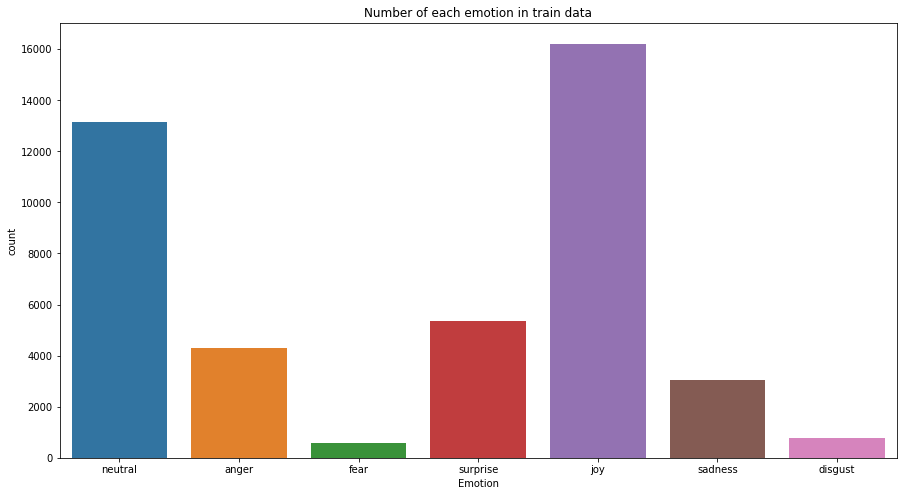

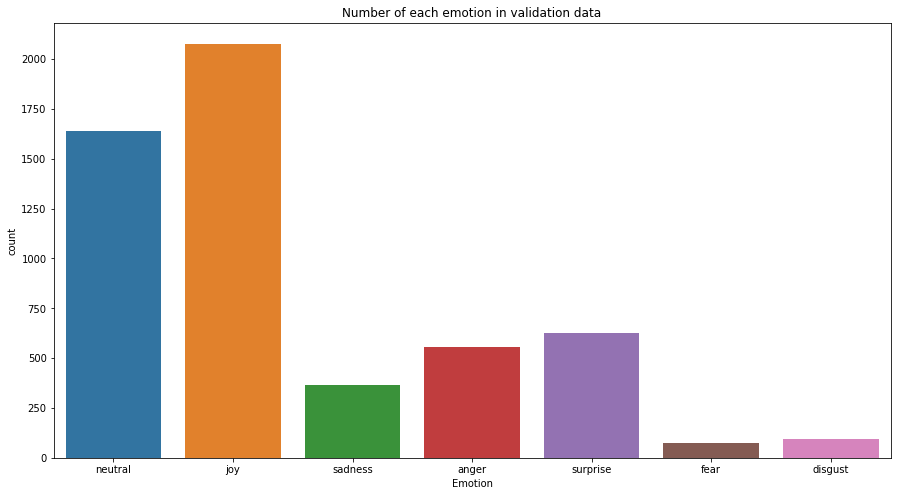

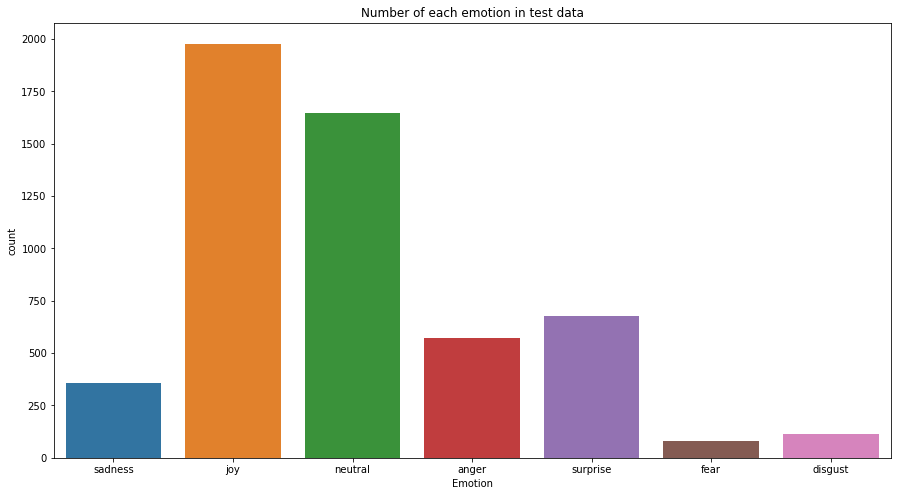

In [187]:
# Using seaborn to plot the emotions

plt.figure(figsize=(15, 8))
plt.title("Number of each emotion in train data")
sns.countplot(x="Emotion", data=train_data);
plt.figure(figsize=(15, 8))
plt.title("Number of each emotion in validation data")
sns.countplot(x="Emotion", data=val_data);
plt.figure(figsize=(15, 8))
plt.title("Number of each emotion in test data")
sns.countplot(x="Emotion", data=test_data);
plt.show()

## Preprocessing Datasets

Add an extra column "Length" to show the number of words in original sentence

In [188]:
train_data['Length'] = train_data["Text"].apply(lambda x:len(x.split()))
val_data['Length'] = val_data["Text"].apply(lambda x:len(x.split()))
test_data['Length'] = test_data["Text"].apply(lambda x:len(x.split()))

In [189]:
train_data

,Text,Emotion,Id,Length
0,My favourite food is anything I didn't have to...,neutral,eebbqej,11
1,"Now if he does off himself, everyone will thin...",neutral,ed00q6i,20
2,WHY THE FUCK IS BAYLESS ISOING,anger,eezlygj,6
3,To make her feel threatened,fear,ed7ypvh,5
4,Dirty Southern Wankers,anger,ed0bdzj,3
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,joy,edsb738,26
43406,Always thought that was funny but is it a refe...,surprise,ee7fdou,12
43407,What are you talking about? Anything bad that ...,anger,efgbhks,19
43408,"More like a baptism, with sexy results!",joy,ed1naf8,7


### Text Cleaning
Before running the model we have to clean out text
+ Remove noise
    - stopwords
    - special characters
    - punctuations
    - emojis


We use text-hammer, a preprocessing package, to remove special characters, punctuations, and emojis from text. Another fantstic feature of text-hammer is creating base form of each eord by using "make_base" function that help us to ignore different forms of one word.

In [190]:
!pip install text-hammer
import text_hammer as th

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [259]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook # Jupyter Notebook progressbar decorator for iterators.
tqdm_notebook.pandas()

def text_preprocessing(df,col_name, new_col):
    column = col_name
    n_column = new_col
    df[n_column] = df[column].progress_apply(lambda x:str(x).lower())
    # df[n_column] = df[n_column].progress_apply(lambda x: th.remove_stopwords(x))
    df[n_column] = df[n_column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[n_column] = df[n_column].progress_apply(lambda x: th.remove_emails(x))
    df[n_column] = df[n_column].progress_apply(lambda x: th.remove_html_tags(x))
    df[n_column] = df[n_column].progress_apply(lambda x: th.remove_special_chars(x))
    df[n_column] = df[n_column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[n_column] = df[n_column].progress_apply(lambda x: th.make_base(x)) #ran -> run,

CPU times: user 447 µs, sys: 0 ns, total: 447 µs
Wall time: 455 µs


Use text_preprocessing function to remove noises from text and save it as a new column "Clean_Text". This must be applied on train, validation, and test dataset.

In [261]:
text_preprocessing(train_data, "Text", "Clean_Text")
text_preprocessing(val_data, "Text", "Clean_Text")
text_preprocessing(test_data, "Text", "Clean_Text")

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [262]:
# To see what happend to our dataset
train_data

,Text,Emotion,Id,Clean_Text
0,My favourite food is anything I didn't have to...,neutral,eebbqej,my favourite food is anything I do not have to...
1,"Now if he does off himself, everyone will thin...",neutral,ed00q6i,now if he do off himself everyone will think h...
2,WHY THE FUCK IS BAYLESS ISOING,anger,eezlygj,why the fuck is bayless isoing
3,To make her feel threatened,fear,ed7ypvh,to make she feel threaten
4,Dirty Southern Wankers,anger,ed0bdzj,dirty southern wanker
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,joy,edsb738,add you mate well I ve just get the bow and I ...
43406,Always thought that was funny but is it a refe...,surprise,ee7fdou,always think that was funny but is it a refere...
43407,What are you talking about? Anything bad that ...,anger,efgbhks,what are you talk about anything bad that happ...
43408,"More like a baptism, with sexy results!",joy,ed1naf8,more like a baptism with sexy result


In [263]:
train_data['N_Length'] = train_data["Clean_Text"].apply(lambda x:len(x.split()))
val_data['N_Length'] = val_data["Clean_Text"].apply(lambda x:len(x.split()))
test_data['N_Length'] = test_data["Clean_Text"].apply(lambda x:len(x.split()))

After removing noise from datasets, some of cleaned text might have no word. In another word the length of some cleaned texts might be zero. So I decided to remove these rows from dataset.

In [264]:
# to remove 0 text length after preprocessing

for index in train_data.index:
  if train_data["N_Length"][index] == 0:
    train_data = train_data.drop(index)
for index in val_data.index:
  if val_data["N_Length"][index] == 0:
    val_data = val_data.drop(index)
for index in test_data.index:
  if test_data["N_Length"][index] == 0:
    test_data = test_data.drop(index)


### Keyword Extraction and visulise Cleaned Text
+ Extract most commen words per class of emotion
+ Show some plot to check cleaned Text

In [265]:
from collections import Counter

def extract_keywords(text, num=50):
  tokens = [token for token in text.split()]
  most_common_token = Counter(tokens).most_common(num)

  return dict(most_common_token)

In [266]:
# List of emotions
emotion_l = train_data["Emotion"].unique().tolist()
print("The list of emotions is:", emotion_l)

The list of emotions is: ['neutral', 'anger', 'fear', 'surprise', 'joy', 'sadness', 'disgust']


In [267]:
joy_l = train_data[train_data["Emotion"] == "joy"]["Clean_Text"].tolist()
joy_docx = " ".join(joy_l)
keyword_joy = extract_keywords(joy_docx)

In [268]:
# Plot most common words

def plot_most_common_words(word_dict, emotions):
  data = pd.DataFrame(word_dict.items(), columns=["Token", "Count"])
  plt.figure(figsize=(20, 10))
  plt.title("{} emotion most common words".format(emotions))
  sns.barplot(x="Token", y="Count", data=data)
  plt.xticks(rotation=45)
  plt.show()

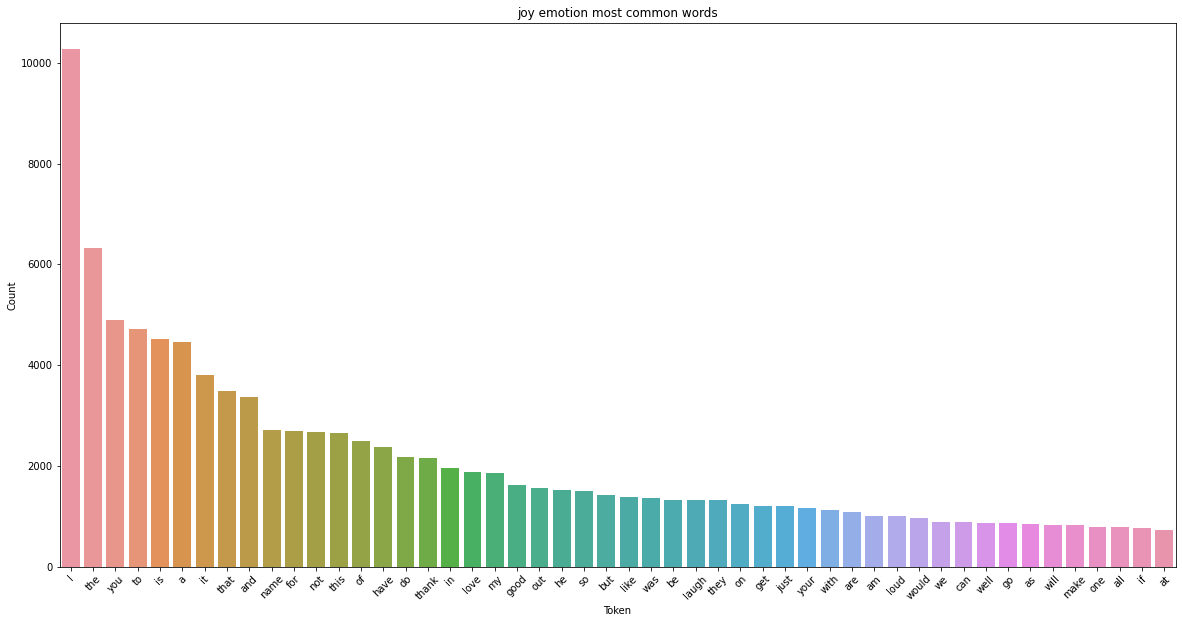

In [269]:
plot_most_common_words(keyword_joy, "joy")

In [270]:
surprise_l = train_data[train_data["Emotion"] == "surprise"]["Clean_Text"].tolist()
surprise_docx = " ".join(surprise_l)
keyword_surprise = extract_keywords(surprise_docx)

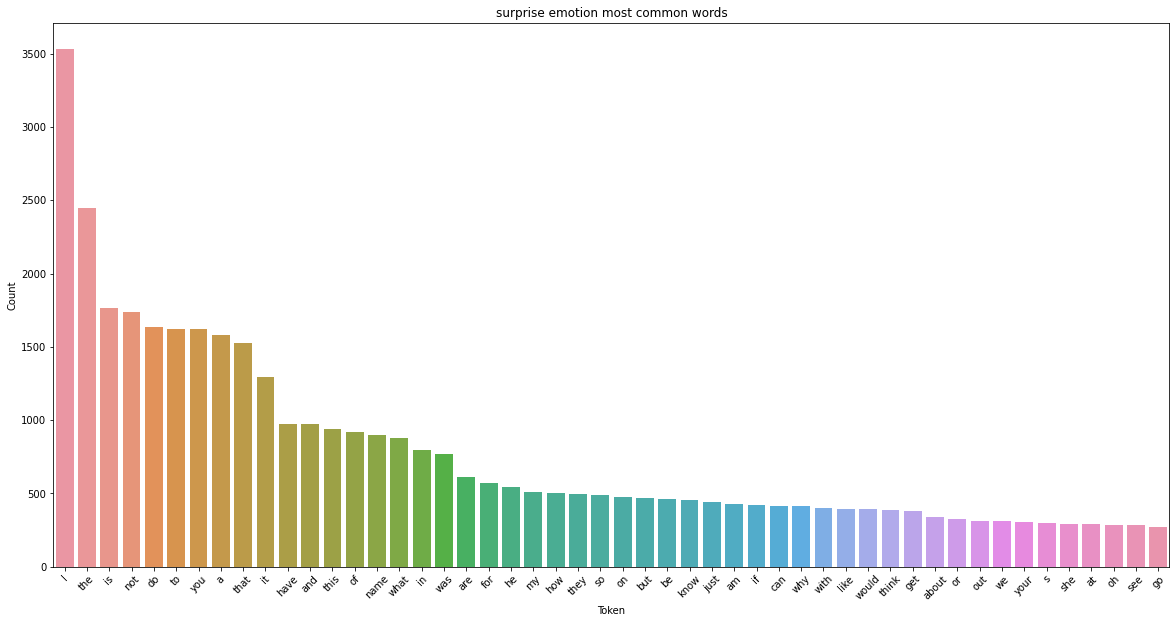

In [271]:
plot_most_common_words(keyword_surprise, "surprise")

In [272]:
from wordcloud import WordCloud

def plot_wordcloud(docx):
  word_cloud = WordCloud().generate(docx)
  plt.figure(figsize=(20,10))
  plt.imshow(word_cloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

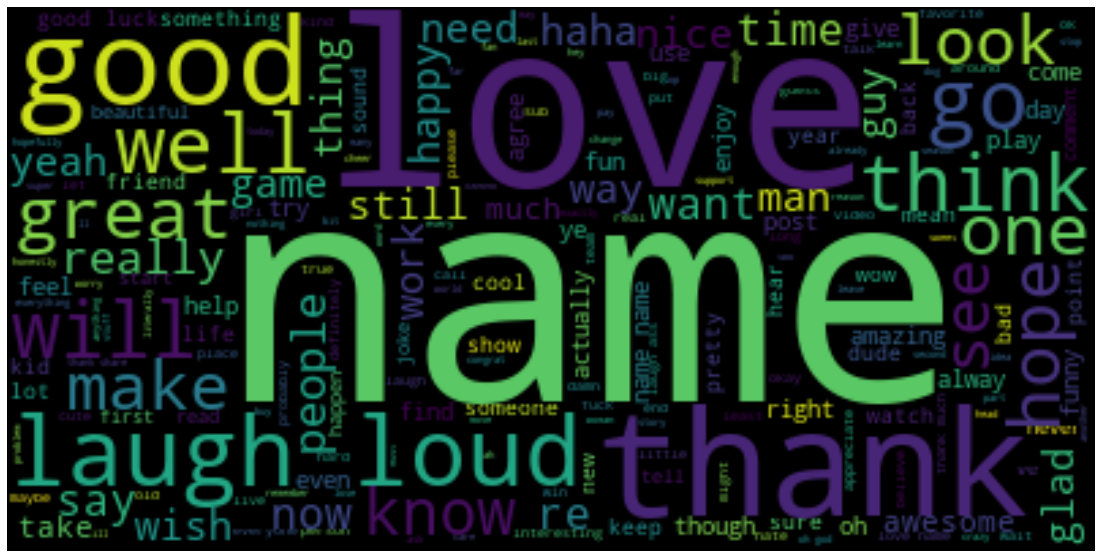

In [273]:
plot_wordcloud(joy_docx)

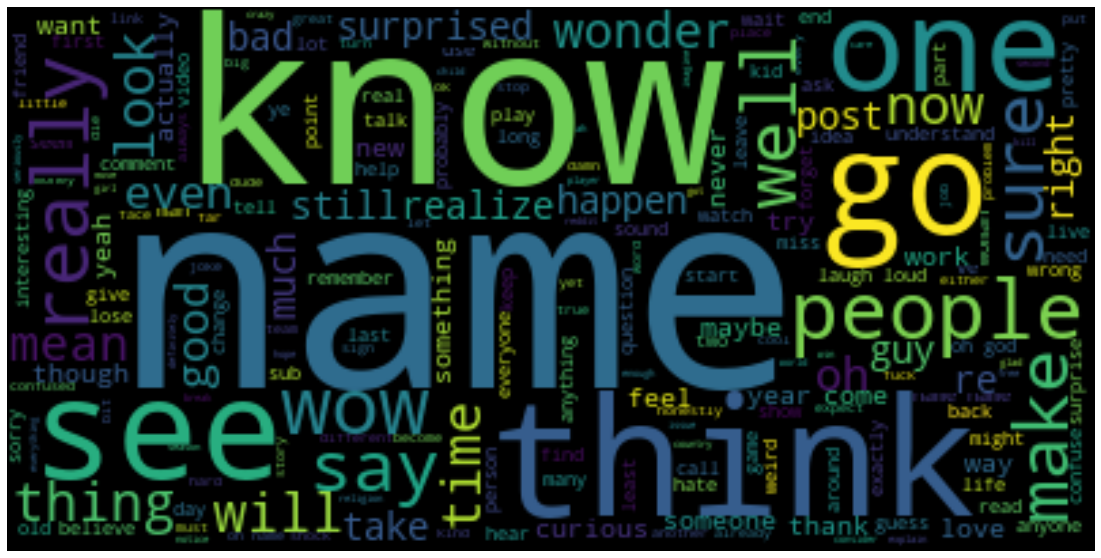

In [274]:
plot_wordcloud(surprise_docx)

In [206]:
# train_data["word_length"] = train_data["New_Text"].apply(lambda x:len(x.split()))

In [207]:
# train_data

In [208]:
train_data.groupby("Emotion").mean()

,Length,N_Length
Emotion,,
anger,13.146983,7.448171
disgust,12.955729,7.350260
fear,13.294118,7.286988
joy,12.531610,7.136125
neutral,12.483864,6.782330
sadness,13.843689,7.609876
surprise,13.839113,7.383110


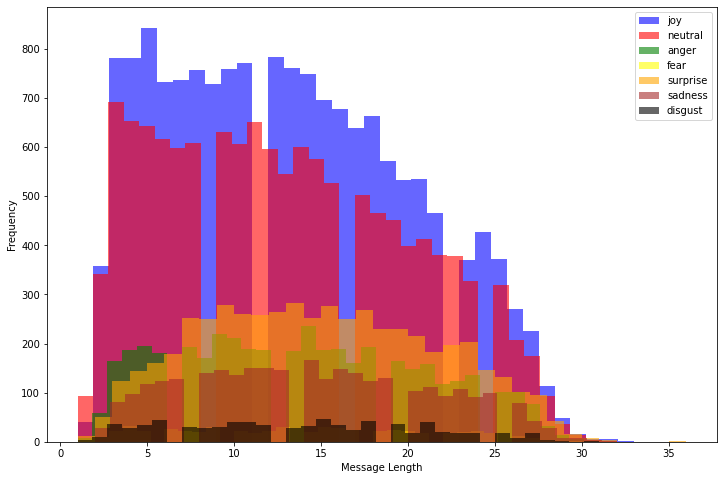

In [275]:
# To show the frequency of each words based on emotion
plt.figure(figsize=(12,8))
train_data[train_data.Emotion == "joy"].N_Length.plot(bins=35, kind="hist", color="blue", label="joy", alpha=0.6)
train_data[train_data.Emotion == "neutral"].N_Length.plot(bins=35, kind="hist", color="red", label="neutral", alpha=0.6)
train_data[train_data.Emotion == "anger"].N_Length.plot(bins=35, kind="hist", color="green", label="anger", alpha=0.6)
train_data[train_data.Emotion == "fear"].N_Length.plot(bins=35, kind="hist", color="yellow", label="fear", alpha=0.6)
train_data[train_data.Emotion == "surprise"].N_Length.plot(bins=35, kind="hist", color="orange", label="surprise", alpha=0.6)
train_data[train_data.Emotion == "sadness"].N_Length.plot(bins=35, kind="hist", color="brown", label="sadness", alpha=0.6)
train_data[train_data.Emotion == "disgust"].N_Length.plot(bins=35, kind="hist", color="black", label="disgust", alpha=0.6)

plt.legend()
plt.xlabel("Message Length")
plt.show()

### Tokenizing
Using The tokenizer Class to convert the sentences into word vectors.

Tokenization is one of the most important steps in text pre-processing. Whether you are working with traditional NLP techniques or using advanced deep-learning techniques, you cannot skip this step.

Tokenization in simple words is the process of splitting a phrase, sentence, paragraph, one or multiple text documents into smaller units. Each of these smaller units is called a token. Now, these tokens can be anything — a word, a subword, or even a character. 


In [276]:
from keras.preprocessing.text import Tokenizer

num_words = 25000 # this means 25000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([train_data["Clean_Text"], val_data["Clean_Text"], test_data["Clean_Text"]], axis = 0)
tokenizer.fit_on_texts(df_total)

In [277]:
len(tokenizer.word_index)

25570

### Padding
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [278]:
from keras.preprocessing.sequence import pad_sequences

X_train=tokenizer.texts_to_sequences(train_data["Clean_Text"]) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=20,padding='post') # this makes the length of all numeric sequences equal 

X_test = tokenizer.texts_to_sequences(test_data["Clean_Text"])
X_test_pad = pad_sequences(X_test, maxlen=20, padding = 'post')

X_val = tokenizer.texts_to_sequences(val_data["Clean_Text"])
X_val_pad = pad_sequences(X_val, maxlen=20, padding = 'post')

As computer works with numerical data, we have to transform categorical Emotion data to numerical using "LabelBinarizer"

In [279]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y_train = lb.fit_transform(train_data["Emotion"])
y_val = lb.fit_transform(val_data["Emotion"])
y_test = lb.fit_transform(test_data["Emotion"])

In [280]:
# To check shape of each sentence in datasets

print("The shape of train data after padding:", X_train_pad.shape)
print("The shape of validation data after padding:", X_val_pad.shape)
print("The shape of test data after padding:", X_test_pad.shape)

The shape of train data after padding: (43406, 20)
The shape of validation data after padding: (5426, 20)
The shape of test data after padding: (5427, 20)


For creating weight matrix we are using fasttext. we are going to use fasttext since we dont wanna loose the context meaning


In [298]:
# Fasttext
import gensim.downloader as api
fasttext = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300


[==================================================] 100.0% 958.5/958.4MB downloaded


In [299]:
weight_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < num_words: # since index starts with zero 
        if word in fasttext.vocab:
            weight_matrix[i] = fasttext[word]
        else:
            weight_matrix[i] = np.zeros(300)


In [284]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Flatten, SimpleRNN, Conv1D, MaxPooling1D
import tensorflow
# tf.compat.v1.keras.layers.CuDNNLSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

## Model
For Embedding layer, we use pretrained Fasttext word embedding.

We also use Bidirectional LSTM with GPU(CUDNN).Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper. This wrapper takes a recurrent layer (e.g. the first LSTM layer) as an argument. It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer.

We also use CuDNNLSTM. According to the Keras documentation, a CuDNNLSTM is a:Fast LSTM implementation backed by CuDNN. Can only be run on GPU, with the TensorFlow backend.

In [309]:
EMBEDDING_DIM = 300 # this means the embedding layer will create  a vector in 300 dimension

model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [weight_matrix],trainable = False))
model.add(Dropout(0.4))
model.add(Bidirectional(CuDNNLSTM(50,return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(CuDNNLSTM(50,return_sequences=False)))

model.add(Dense(7, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [310]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 20, 300)           7500000   
                                                                 
 dropout_90 (Dropout)        (None, 20, 300)           0         
                                                                 
 bidirectional_67 (Bidirecti  (None, 20, 100)          140800    
 onal)                                                           
                                                                 
 dropout_91 (Dropout)        (None, 20, 100)           0         
                                                                 
 bidirectional_68 (Bidirecti  (None, 20, 200)          161600    
 onal)                                                           
                                                                 
 dropout_92 (Dropout)        (None, 20, 200)         

In [311]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 30, batch_size = 100, validation_data=(X_val_pad, y_val),verbose = 1)

Epoch 1/30
435/435 [==============================] - 11s 17ms/step - loss: 1.3634 - accuracy: 0.4818 - val_loss: 1.2033 - val_accuracy: 0.5389
Epoch 2/30
435/435 [==============================] - 6s 15ms/step - loss: 1.2085 - accuracy: 0.5449 - val_loss: 1.1271 - val_accuracy: 0.5750
Epoch 3/30
435/435 [==============================] - 6s 15ms/step - loss: 1.1601 - accuracy: 0.5622 - val_loss: 1.0936 - val_accuracy: 0.5875
Epoch 4/30
435/435 [==============================] - 6s 15ms/step - loss: 1.1293 - accuracy: 0.5731 - val_loss: 1.0703 - val_accuracy: 0.5875
Epoch 5/30
435/435 [==============================] - 6s 15ms/step - loss: 1.1060 - accuracy: 0.5815 - val_loss: 1.0624 - val_accuracy: 0.5949
Epoch 6/30
435/435 [==============================] - 6s 15ms/step - loss: 1.0894 - accuracy: 0.5886 - val_loss: 1.0514 - val_accuracy: 0.6054
Epoch 7/30
435/435 [==============================] - 6s 15ms/step - loss: 1.0732 - accuracy: 0.5928 - val_loss: 1.0334 - val_accuracy: 0.612

In [316]:
model.save_weights("/content/drive/MyDrive/NLP_Deep.h5")

## Evaluation

Plot accuracy of model

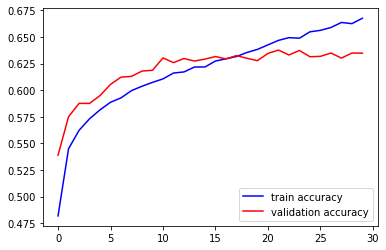

In [312]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [313]:
model.evaluate(X_test_pad, y_test) 

170/170 [==============================] - 1s 7ms/step - loss: 1.0203 - accuracy: 0.6278


[1.0202951431274414, 0.6277869939804077]

Calculate F1-macro average

In [314]:
from sklearn import metrics

y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.40      0.42       572
           1       0.52      0.29      0.37       116
           2       0.55      0.64      0.59        81
           3       0.77      0.76      0.77      1978
           4       0.57      0.70      0.62      1648
           5       0.56      0.51      0.54       355
           6       0.58      0.38      0.46       677

    accuracy                           0.63      5427
   macro avg       0.57      0.53      0.54      5427
weighted avg       0.63      0.63      0.62      5427

